In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(r'\\phont80025us.homeoffice.wal-mart.com\Shares\Audit_Analytics\FY20\Item_Matching')
import re

import datetime
print datetime.datetime.utcnow()
raw = pd.read_csv('raw_1_item_match.csv')

2019-07-08 02:55:10.146000


In [2]:
from fuzzywuzzy import fuzz

#### Examples showing how this package works
Str1 = "ZARBEE'S BABY MUCUS"
Str2 = 'ZARBEES BABY MUCUS'

Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
Token_Sort_Ratio = fuzz.token_sort_ratio(Str1,Str2)
Token_Set_Ratio = fuzz.token_set_ratio(Str1,Str2)
print(Ratio)                #---------Levenshtein
print(Partial_Ratio)
print(Token_Sort_Ratio)     
print(Token_Set_Ratio)      #---------Jaccard

97
94
92
92


In [3]:
Str1 = "united states v. nixon"
Str2 = "Nixon v. United States"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
Token_Sort_Ratio = fuzz.token_sort_ratio(Str1,Str2)
print(Ratio)
print(Partial_Ratio)
print(Token_Sort_Ratio)

59
74
100


In [4]:
#### to have every possible combination of mft and cate group

df_mft_cate = pd.pivot_table(raw,index =['UPC_mft_code_1','Dept Category Group Description'],
                            values = ['Prime Item Nbr'],
                            aggfunc = lambda x: len(x.unique()))
df_mft_cate =  df_mft_cate.reset_index()
df_mft_cate.columns = ['UPC_mft_code_1','Dept Category Group Description','Item_Count']

### if the mft only exist in 1 cate group, there's no need to compare the items with such mft code

df_mft_count = pd.pivot_table(df_mft_cate,index =['UPC_mft_code_1'],
                            values = ['Dept Category Group Description'],
                            aggfunc = lambda x: len(x.unique()))
df_mft_count = df_mft_count.reset_index()
df_mft_count.columns = ['UPC_mft_code_1','Cate_Group_Count']

mft_1Cate = list(df_mft_count[df_mft_count['Cate_Group_Count']<=1]['UPC_mft_code_1'])
mft_nCate = list(df_mft_count[df_mft_count['Cate_Group_Count']>1]['UPC_mft_code_1'])

## Compare items with mft which exist in multiple category groups
bool1 = [i in mft_nCate for i in df_mft_cate['UPC_mft_code_1']]
mft_cate_compare = df_mft_cate[bool1]

#-------------------------
#---- Use this reseult----
#-------------------------
mft_cate_compare = mft_cate_compare.sort_values (by = ['UPC_mft_code_1','Item_Count'],ascending = True )

## if the items with mft which exist in only 1 category group, compare such items if they are managed by multiple buyers
### in other words, no need to compare items managed by only 1 buyer
bool2 = [i in mft_1Cate for i in raw['UPC_mft_code_1']]
df2 = raw[bool2]

df2_1 = pd.pivot_table(df2,index =['UPC_mft_code_1'],
                            values = ['Buyer Full Name'],
                            aggfunc = lambda x: len(x.unique()))
df2_1 = df2_1.reset_index()
df2_1.columns = ['UPC_mft_code_1','Buyer_Count']

mft_1Buyer = list(df2_1[df2_1['Buyer_Count']<=1]['UPC_mft_code_1'])
mft_1Cate_nBuyer = list(df2_1[df2_1['Buyer_Count']>1]['UPC_mft_code_1'])

bool3 = [i in mft_1Cate_nBuyer for i in raw['UPC_mft_code_1']]
df3 = raw[bool3]

mft_buyer_compare = pd.pivot_table(df3,index =['UPC_mft_code_1','Buyer Full Name'],
                            values = ['Prime Item Nbr'],
                            aggfunc = lambda x: len(x.unique()))

mft_buyer_compare = mft_buyer_compare.reset_index()
mft_buyer_compare.columns = ['UPC_mft_code_1','Buyer Full Name','Item_Count']
#-------------------------
#---- Use this reseult----
#-------------------------
mft_buyer_compare = mft_buyer_compare.sort_values(by = ['UPC_mft_code_1','Item_Count'],ascending = True)


In [5]:
# Create function to conduct text comparison
DB_items = list(raw[raw['Dept Category Group Description'] =='DME BP DIABETES']['Prime Item Desc'])
Cat_items = list(raw[raw['Dept Category Group Description'] =='CAT FOOD/LITTER']['Prime Item Desc'])
Dog_items = list(raw[raw['Dept Category Group Description'] =='DOG FOOD']['Prime Item Desc'])

def Item_Desc_Compare (Str1,Str2):
    
    cond_cat1 = (' cat' in Str1.lower()) & (' cat' not in Str2.lower())
    cond_cat2 = (' cat' in Str2.lower()) & (' cat' not in Str1.lower())

    cond_dog1 = (' dog' in Str1.lower()) & (' dog' not in Str2.lower())
    cond_dog2 = (' dog' in Str2.lower()) & (' dog' not in Str1.lower())
    
    cond_baby1 = (' baby' in Str1.lower()) & (' baby' not in Str2.lower())
    cond_baby2 = (' baby' in Str2.lower()) & (' baby' not in Str1.lower())
    
    cond_kid1 = (' kid' in Str1.lower()) & (' kid' not in Str2.lower())
    cond_kid2 = (' kid' in Str2.lower()) & (' kid' not in Str1.lower())

    if (Str1 in Cat_items)or (Str2 in Cat_items):
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio = 0
                
    
    elif (Str1 in Dog_items)or (Str2 in Dog_items):
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =0
        
    elif cond_cat1 or cond_cat2:
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =0
        
    elif cond_dog1 or cond_dog2:
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =0
        
    elif cond_baby1 or cond_baby2:
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =0
        
    elif cond_kid1 or cond_kid2:
        Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =0
        
    #elif (Str1 in DB_items)or (Str2 in DB_items):
     #   Ratio = Partial_Ratio = Token_Sort_Ratio = Token_Set_Ratio =Avg_Ratio = 0
    
    else:
        Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
        Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
        Token_Sort_Ratio = fuzz.token_sort_ratio(Str1,Str2)
        Token_Set_Ratio = fuzz.token_set_ratio(Str1,Str2)        
    return(Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio)
    

In [6]:
Str1,Str2 = '4746906046','4746905865'
Item_Desc_Compare (Str1,Str2)

(70, 70, 70, 70)

In [7]:
#-------------------------
#---- mft_cate_compare----
#------------------------- 


#-------------------------------------------------------------------------------------------------
#---Step1 Build the data frame contains every possible mft and category group combination
#---and without repeat,such that running time will be reduced
#------------------------------------------------------------------------------------------------- 
res_mft_cate = pd.DataFrame(columns =['UPC_mft_code_1',
                             'Item_NBR1','UPC1','Cate_Group1','Item_Desc1','Dept_NBR1','Vendor_Name1','Vendor_NBR1'
                             'Item_NBR2','UPC2','Cate_Group2','Item_Desc2','Dept_NBR2','Vendor_Name2','Vendor_NBR2'])
                             ##,'Ratio','Partial_Ratio','Token_Sort_Ratio','Token_Set_Ratio'])
    

for k in mft_cate_compare['UPC_mft_code_1'].unique():
    bool_mft = raw['UPC_mft_code_1'] == k
    test = mft_cate_compare[mft_cate_compare['UPC_mft_code_1'] == k]
    test.index = range(len(test))
    for i in range(len(test))[:-1]:
        cate1 = test.loc[i,'Dept Category Group Description']
        bool_cate1 = raw['Dept Category Group Description'] == cate1    
        subset1 = raw[bool_mft&bool_cate1]
        lst1 = zip(subset1['Prime Item Nbr'],
                   subset1['Dept Category Group Description'],
                   subset1['UPC'],
                   subset1['Prime Item Desc']
                  ,subset1['Acct Dept Nbr']
                  ,subset1['Vendor Name']
                  ,subset1['Vendor Nbr'])
    
        if i< range(len(test))[-1]:
            ix_list = range(len(test))[i+1:]
            for j in ix_list:         
                cate2 = test.loc[j,'Dept Category Group Description']
                bool_cate2 = raw['Dept Category Group Description'] == cate2
                subset2 = raw[bool_mft&bool_cate2]         
                lst2 = zip(subset2['Prime Item Nbr'], 
                           subset2['Dept Category Group Description'],
                           subset2['UPC'],
                           subset2['Prime Item Desc']
                          ,subset2['Acct Dept Nbr']
                          ,subset2['Vendor Name'],
                          subset1['Vendor Nbr'])
                temp = [m + n for m in lst1 for n in lst2]
            
                df_temp = pd.DataFrame(temp)
                df_temp.columns = ['Item_NBR1','Cate_Group1','UPC1','Item_Desc1','Dept_NBR1','Vendor_Name1','Vendor_NBR1',
                             'Item_NBR2','Cate_Group2','UPC2','Item_Desc2','Dept_NBR2','Vendor_Name2','Vendor_NBR2']
                df_temp['UPC_mft_code_1'] = test.loc[i,'UPC_mft_code_1']
            
                res_mft_cate = pd.concat([res_mft_cate, df_temp],sort=False)
    
res_mft_cate.index = range(len(res_mft_cate)) 

#Vendor Name Vendor Nbr



In [8]:

Scores_mft_cate = res_mft_cate.apply(lambda x: Item_Desc_Compare(x['Item_Desc1'],x['Item_Desc2']), axis=1)


In [9]:
df_Scores = pd.DataFrame(list(Scores_mft_cate))

df_Scores.columns = ['Ratio','Partial_Ratio','Token_Sort_Ratio','Token_Set_Ratio']
df_Scores['Std_Score'] = df_Scores.std(axis=1)
df_Scores['Min'] = df_Scores[['Ratio','Partial_Ratio','Token_Sort_Ratio','Token_Set_Ratio']].min(axis=1)
df_Scores['Max'] = df_Scores.max(axis=1)
df_Scores['Max_0'] = df_Scores[['Ratio','Token_Sort_Ratio','Token_Set_Ratio']].max(axis=1)
df_Scores['Avg'] = df_Scores[['Ratio','Partial_Ratio','Token_Sort_Ratio','Token_Set_Ratio']].mean(axis=1)
df_Scores['Avg_0'] = df_Scores[['Ratio','Token_Sort_Ratio','Token_Set_Ratio']].mean(axis=1)

df_Scores['Sort_LV'] = abs((df_Scores['Token_Sort_Ratio']-df_Scores['Ratio'])/df_Scores['Ratio'])
df_Scores['Sort_JC'] = abs((df_Scores['Token_Sort_Ratio']-df_Scores['Token_Set_Ratio'])/df_Scores['Token_Set_Ratio'])

df_Scores['Part_LV'] = abs((df_Scores['Partial_Ratio']-df_Scores['Ratio'])/df_Scores['Ratio'])
df_Scores['Part_JC'] = abs((df_Scores['Partial_Ratio']-df_Scores['Token_Set_Ratio'])/df_Scores['Token_Set_Ratio'])


res_mft_cate_score = pd.merge(res_mft_cate,df_Scores,left_index=True, right_index=True)

In [10]:
res_mft_cate_score[res_mft_cate_score['Std_Score']>15].to_csv('std15.csv',index = False,encoding='utf_8_sig')

In [11]:

bool1 = res_mft_cate_score['Ratio']>40
bool2 = res_mft_cate_score['Token_Set_Ratio']>60
res_mft_cate_score[bool1&bool2].to_csv('test1.csv',index = False,encoding='utf_8_sig')

In [12]:
bool1 = res_mft_cate_score['Token_Sort_Ratio']<64
bool2 = res_mft_cate_score['Token_Set_Ratio']>80
res_mft_cate_score[bool1&bool2].to_csv('2.3.csv',index = False,encoding='utf_8_sig')

In [13]:
res_mft_cate_score[res_mft_cate_score['Item_NBR2'] == 4070131]


,UPC_mft_code_1,Item_NBR1,UPC1,Cate_Group1,Item_Desc1,Dept_NBR1,Vendor_Name1,Vendor_NBR1Item_NBR2,UPC2,Cate_Group2,...,Std_Score,Min,Max,Max_0,Avg,Avg_0,Sort_LV,Sort_JC,Part_LV,Part_JC


In [14]:
df_cutoff = pd.DataFrame()
start = max(min(res_mft_cate_score['Max_0']),min(res_mft_cate_score['Max']))
cutoff_list = range(start,100)
for i in range(len(cutoff_list)):
    df_cutoff.loc[i,'Cutoff']=cutoff_list[i]
    df_cutoff.loc[i,'Max'] = sum(res_mft_cate_score['Max']>i)
    df_cutoff.loc[i,'Max0'] = sum(res_mft_cate_score['Max_0']>i)
    df_cutoff.loc[i,'Avg'] = sum(res_mft_cate_score['Avg']>i)
    df_cutoff.loc[i,'Avg0'] = sum(res_mft_cate_score['Avg']>i)
    df_cutoff.loc[i,'Min'] = sum(res_mft_cate_score['Min']>i)

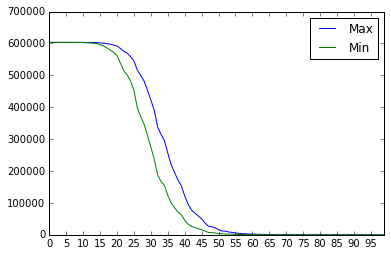

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

t = df_cutoff['Cutoff']
plt.xticks(np.arange(start, 101, 5))
#plt.yticks(np.arange(0, 1500000, 1000))
plt.plot( t, df_cutoff['Max0'],t, df_cutoff['Min'])

plt.gca().legend(('Max','Min'))

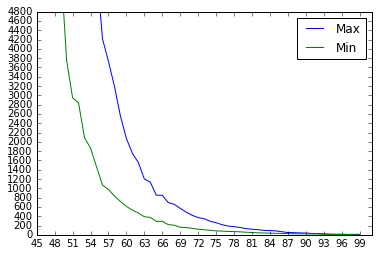

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis([60,101,100,2000])

t = df_cutoff['Cutoff']
plt.xticks(np.arange(45, 101, 3))
plt.yticks(np.arange(0, 5000,200))
plt.plot( t, df_cutoff['Max0'],t, df_cutoff['Min'])

plt.gca().legend(('Max','Min'))

In [26]:
os.chdir(r'C:\Users\t0d00dh\01_Projects\Item_Matching')
cond1 = res_mft_cate_score['Min']>63
cond2 = res_mft_cate_score['Max_0']>66
cond3 = res_mft_cate_score['Avg_0']>71
poss_match = res_mft_cate_score[cond1&cond2]
poss_match.to_csv('poss_match_min63max66_0707.csv',index = False,encoding='utf_8_sig')

In [18]:
poss_match = res_mft_cate_score[cond2]
poss_match.to_csv('poss_match_max71_0707.csv',index = False,encoding='utf_8_sig')

In [19]:
muli_match1 = pd.pivot_table(poss_match,index =['Item_NBR1','Item_Desc1'],
                            values = ['Item_NBR2','Cate_Group2'],
                            aggfunc = lambda x: len(x.unique()))
muli_match1 = muli_match1.reset_index()
muli_match1 = muli_match1.sort_values(by = ['Cate_Group2','Item_NBR2'],ascending = False)

muli_match2 = pd.pivot_table(poss_match,index =['Item_NBR2','Item_Desc2'],
                            values = ['Item_NBR1','Cate_Group1'],
                            aggfunc = lambda x: len(x.unique()))
muli_match2 = muli_match2.reset_index()
muli_match2 = muli_match2.sort_values(by = ['Cate_Group1','Item_NBR1'],ascending = False)
muli_match2.columns = muli_match1.columns


muli_match1.index = range(len(muli_match1))
muli_match2.index = range(len(muli_match2))
multi_match = muli_match1.append(muli_match2,ignore_index=True)

multi_match_new = pd.pivot_table(multi_match,index =['Item_NBR1','Item_Desc1'],
                            values = ['Item_NBR2','Cate_Group2'],
                            aggfunc = np.sum)
multi_match_new = multi_match_new.reset_index()
multi_match_new = multi_match_new.sort_values(by = ['Cate_Group2','Item_NBR2'],ascending  = False)

muli_match2.to_csv('muli_match2.csv',index = False,encoding='utf_8_sig')

In [20]:
print datetime.datetime.utcnow()

2019-07-08 03:04:57.465000
